In [1]:
import torch
import numpy as np

### Load Dataset

In [2]:
from torch.utils.data import DataLoader

In [3]:
data = np.load('./dataset/data64.npy')

In [4]:
data.shape

(3376, 3, 64, 64)

In [5]:
# normalize to [0, 1]
normalizer = lambda p: (p/255)
vfunc = np.vectorize(normalizer)
data_n = vfunc(data)

In [6]:
dataset = DataLoader(data_n,batch_size = 32,shuffle=True)

## VAE

In [7]:
import torch.nn as nn

In [11]:
class VAE(nn.Module):
    
    def __init__(self, latent_size, output_size, n_channels):
        super(VAE,self).__init__()
        params = {'kernel_size': 5, 'stride': 2, 'padding': 2}
        self.init_output = 3
        self.latent_size = latent_size
        self.output_size = output_size
        self.n_channels = n_channels
        self._build_encoder(params)
        self._build_decoder()
        self.reconstruction = nn.Sigmoid()
        
        
    
    def _build_encoder(self,params):
        self.elayer1 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = self.init_output, **params),
            nn.BatchNorm2d(num_features = self.init_output),
            nn.LeakyReLU(0.2)
        )
        self.elayer2 = nn.Sequential(
            nn.Conv2d(in_channels = self.init_output, out_channels = self.init_output*2, **params),
            nn.BatchNorm2d(num_features = self.init_output*2),
            nn.LeakyReLU(0.2)
        )
        self.elayer3 = nn.Sequential(
            nn.Conv2d(in_channels = self.init_output*2, out_channels = self.init_output*4, **params),
            nn.BatchNorm2d(num_features = self.init_output*4),
            nn.LeakyReLU(0.2)
        )
        self.elayer4 = nn.Sequential(
            nn.Conv2d(in_channels = self.init_output*4, out_channels = self.init_output*8, **params),
            nn.BatchNorm2d(num_features = self.init_output*8),
            nn.LeakyReLU(0.2)
        )
        self.emean_output = nn.Sequential(
            nn.Linear(self.init_output*8*16,self.latent_size)
        )
        self.ecovariance_output = nn.Sequential(
            nn.Linear(self.init_output*8*16,self.latent_size),
            # force outputs to be positive
            nn.Softplus()
        )
        self.encoder_layers = [self.elayer1,self.elayer2,self.elayer3,self.elayer4]
    
    def _build_decoder(self):
        self.dlayer1 = nn.Sequential(
            nn.Linear(self.latent_size,self.latent_size*2),
            nn.ReLU()
        )
        self.dlayer2 = nn.Sequential(
            nn.Linear(self.latent_size*2,self.latent_size*4),
            nn.ReLU()
        )
        self.dlayer3 = nn.Sequential(
             nn.Linear(self.latent_size*4,self.output_size**2 * self.n_channels),
             nn.Sigmoid()
        )
        self.decoder_layers = [self.dlayer1,self.dlayer2,self.dlayer3]
        
    def _encode(self, X):
        for layer in self.encoder_layers:
            X = layer(X)
        X = X.view(-1,self.init_output*8*16)
        mu = self.emean_output(X)
        log_sigma = self.ecovariance_output(X)
        return mu,log_sigma

    def _decode(self, Z):
        for layer in self.decoder_layers:
            Z = layer(Z)
        return Z
        
    def sample(self, bs):
        Z = self._decode(torch.randn(bs,self.latent_size).cuda())
        return Z.view(-1,self.n_channels,self.output_size,self.output_size)
        
    def forward(self,X):
        mu,log_sigma = self._encode(X)
        # reparaterization trick
        Z = mu + torch.exp(log_sigma)*torch.randn(log_sigma.shape).cuda()
        Z = self._decode(Z)
        
        return mu,log_sigma,Z.view(-1,self.n_channels,self.output_size,self.output_size)

In [56]:
vae = VAE(100,64,3).cuda()

In [57]:
optimizer = torch.optim.Adam(vae.parameters(),lr = 0.0002, betas = (0.5,0.999))
n_epochs = 100

for e in range(n_epochs):
    losses = []
    KL_losses = []
    for i,batch in enumerate(dataset):
        vae.zero_grad()
        batch_ = batch.float().cuda()
        mu,log_sigma,out = vae(batch_)
        

        # losses
        KL = -1/2 * torch.sum(1 + 2*log_sigma - torch.pow(mu,2) - torch.exp(2*log_sigma) ,1)
        KL_losses.append(torch.mean(KL.data))
        
        bce = -torch.sum(torch.sum(torch.sum( batch_ * torch.log(1e-10 + out) + (1-batch_) * torch.log(1e-10 + (1-out)), 1),1),1)
        
        loss = torch.mean(bce) + torch.mean(KL)
        losses.append(loss.data)

        loss.backward()
        optimizer.step()
    print('Epoch {e}: Loss: {loss} KL: {lol}'.format(e=e, loss = np.mean(losses), lol = np.mean(KL_losses)))
    if e%5 == 0:
        ex = vae.sample(12).cpu().detach().numpy()
        out = np.moveaxis(ex,1,3)
    #     imgs = vf(out)
    #     imgs = np.clip(img,0,255).astype('uint8')
        np.save('./results/vae_anime_epoch_' + str(e),out)
    

Epoch 0: Loss: 8025.83056640625 KL: 46.82683563232422
Epoch 1: Loss: 7601.205078125 KL: 28.988454818725586
Epoch 2: Loss: 7497.9482421875 KL: 28.779876708984375
Epoch 3: Loss: 7443.75634765625 KL: 28.910011291503906
Epoch 4: Loss: 7427.87255859375 KL: 28.35698127746582
Epoch 5: Loss: 7411.8642578125 KL: 28.654438018798828
Epoch 6: Loss: 7397.38916015625 KL: 29.737119674682617
Epoch 7: Loss: 7376.45703125 KL: 30.993526458740234
Epoch 8: Loss: 7351.17431640625 KL: 33.20664596557617
Epoch 9: Loss: 7327.29833984375 KL: 34.84756088256836
Epoch 10: Loss: 7309.31640625 KL: 36.50064468383789
Epoch 11: Loss: 7294.3076171875 KL: 38.082733154296875
Epoch 12: Loss: 7274.5625 KL: 40.21478271484375
Epoch 13: Loss: 7258.86328125 KL: 41.900760650634766
Epoch 14: Loss: 7236.87451171875 KL: 44.27714157104492
Epoch 15: Loss: 7205.99609375 KL: 46.4713249206543
Epoch 16: Loss: 7188.88623046875 KL: 49.12688446044922
Epoch 17: Loss: 7176.71484375 KL: 51.33318328857422
Epoch 18: Loss: 7172.3466796875 KL: 52.6

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline

In [58]:
out_ = out[8].cpu().data.numpy()
out_ = np.moveaxis(out_,0,2)

In [51]:
denormalizer = lambda p: p*255

In [52]:
vf = np.vectorize(denormalizer)

In [59]:
img = vf(out_)

In [60]:
img = np.clip(img,0,255).astype('uint8')

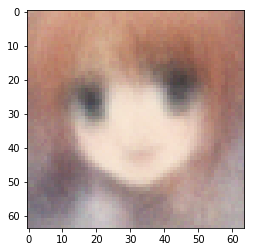

In [61]:
plt.imshow(img)

In [61]:
img

array([[[232, 236, 169],
        [192, 221, 186],
        [184, 162, 227],
        ...,
        [209, 149, 202],
        [125,  77, 116],
        [144,  54, 199]],

       [[237, 210, 179],
        [206, 248, 249],
        [239, 238, 239],
        ...,
        [189,  69, 198],
        [205,  54,  83],
        [211, 139, 216]],

       [[109, 246, 149],
        [152, 212, 228],
        [213, 231, 245],
        ...,
        [168,  61, 154],
        [ 67,  94,  93],
        [121, 156, 184]],

       ...,

       [[ 51, 182,  72],
        [139, 154,  37],
        [ 75,  57,  55],
        ...,
        [144,  54, 182],
        [ 95,  47,  62],
        [ 48,  86,  39]],

       [[168, 102,  44],
        [132,  41,  35],
        [ 61,  33,  39],
        ...,
        [132,  47,  88],
        [ 83, 175, 205],
        [ 82,  15, 130]],

       [[130, 162,  30],
        [170,  34,  25],
        [ 30, 128,  24],
        ...,
        [ 80,  49, 107],
        [187,  37, 106],
        [122,  29,  68]]